In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from utils import *
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\helen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\helen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\helen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
PARENT = "../TelevisionNews/"


cnn, fox, msnbc = get_data(PARENT)

cnn.set_index('DateTime', inplace=True)
cnn=cnn['Snippet']
cnn_month = cnn.groupby(pd.Grouper(freq="M")).count()
cnn_day = cnn.groupby(pd.Grouper(freq="D")).count()
cnn_yr = cnn.groupby(pd.Grouper(freq="Y")).count()

fox.set_index('DateTime', inplace=True)
fox=fox['Snippet']
fox_month = fox.groupby(pd.Grouper(freq="M")).count()
fox_day = fox.groupby(pd.Grouper(freq="D")).count()
fox_yr = fox.groupby(pd.Grouper(freq="Y")).count()

msnbc.set_index('DateTime', inplace=True)
msnbc=msnbc['Snippet']
msnbc_month = msnbc.groupby(pd.Grouper(freq="M")).count()
msnbc_day = msnbc.groupby(pd.Grouper(freq="D")).count()
msnbc_yr = msnbc.groupby(pd.Grouper(freq="Y")).count()

In [91]:
print(cnn_month)
print(cnn_day)
print(cnn_yr)

DateTime
2009-08-31      65
2009-09-30      19
2009-10-31       0
2009-11-30     134
2009-12-31    1506
              ... 
2019-09-30     701
2019-10-31     216
2019-11-30     328
2019-12-31     374
2020-01-31     260
Freq: M, Name: Snippet, Length: 126, dtype: int64
DateTime
2009-08-01     1
2009-08-02     0
2009-08-03     0
2009-08-04     0
2009-08-05     3
              ..
2020-01-17     4
2020-01-18    30
2020-01-19    24
2020-01-20    21
2020-01-21    15
Freq: D, Name: Snippet, Length: 3826, dtype: int64
DateTime
2009-12-31    1724
2010-12-31     752
2011-12-31     609
2012-12-31     745
2013-12-31    1150
2014-12-31    1190
2015-12-31    1971
2016-12-31    2089
2017-12-31    2870
2018-12-31    1340
2019-12-31    4434
2020-12-31     260
Freq: A-DEC, Name: Snippet, dtype: int64


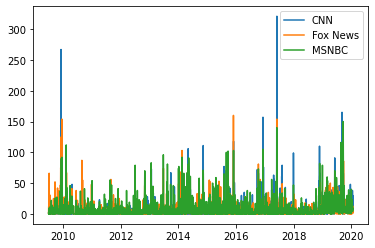

In [94]:
plt.plot(cnn_day, label='CNN')
plt.plot(fox_day, label='Fox News')
plt.plot(msnbc_day, label = 'MSNBC')
plt.legend()

#plt.xlim(0,21)
plt.show()

#cnn.set_index('DateTime', inplace=True)
#temp = temp.groupby(pd.Grouper(freq="M")).count()

#need to plot-align by date???

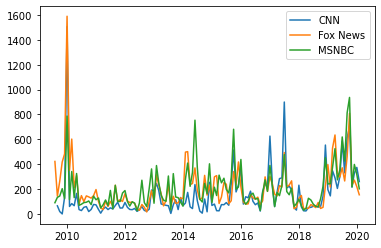

In [95]:
plt.plot(cnn_month, label='CNN')
plt.plot(fox_month, label='Fox News')
plt.plot(msnbc_month, label = 'MSNBC')
plt.legend()

#plt.xlim(0,21)
plt.show()



In [ ]:
#correlation between CNN
#anomaly detection

#normalize by total number of snippets -> then look at correlation




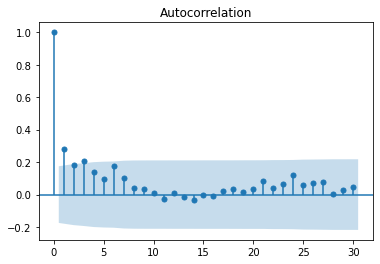

In [96]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(cnn_month, lags=30)
plt.show()

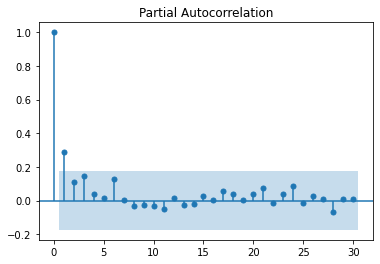

In [97]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(cnn_month, lags=30)
plt.show()

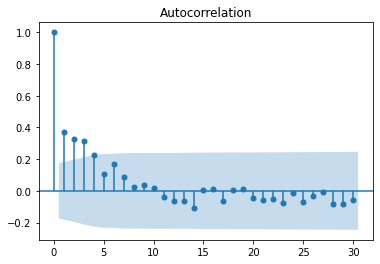

In [98]:
plot_acf(msnbc_month, lags=30)
plt.show()

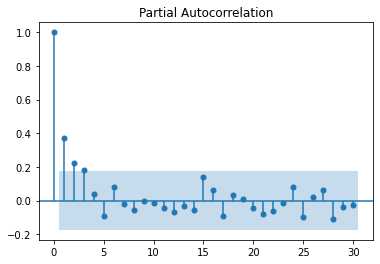

In [99]:
plot_pacf(msnbc_month, lags=30)
plt.show()

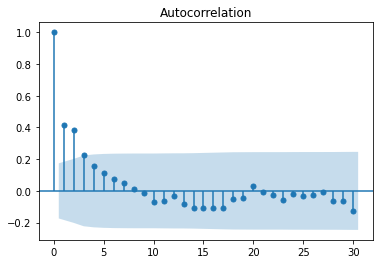

In [100]:
plot_acf(fox_month, lags=30)
plt.show()

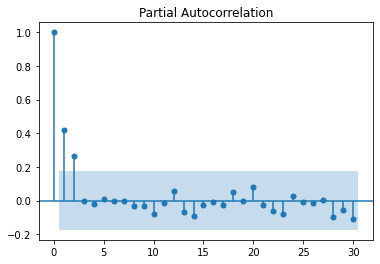

In [102]:
plot_pacf(fox_month, lags=30)
plt.show()

In [107]:
#Questions

#need to plot-align by date???
####need to fill in 2009-10 (missing for CNN)
#print(cnn)
cnn2, fox2, msnbc2 = get_data(PARENT)

#groupby month
cnn_yr2=cnn2.groupby(cnn2.DateTime.dt.to_period("Y")).count()
fox_yr2=fox2.groupby(fox2.DateTime.dt.to_period("Y")).count()
msnbc_yr2=msnbc2.groupby(msnbc2.DateTime.dt.to_period("Y")).count()


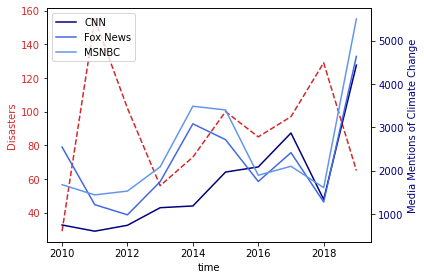

In [120]:
disasters=pd.read_csv('../state-freq-data.csv', header=1)
#print(disasters['year'])
dist_us=disasters.groupby(disasters['year']).sum()
dist_us['Total']=dist_us.drought+dist_us.freeze+dist_us['severe storm']+dist_us['tropical cyclone']+dist_us.wildfire+dist_us['winter storm']
#print(dist_us)

def plot_disasters(disttype):
    t=list(range(2010,2020))

    fig, ax1=plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('Disasters', color=color)
    y=dist_us[disttype].values[(2010-1980):(2019-1980+1)]
    ax1.plot(t, y, "--",color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'navy'
    ax2.set_ylabel('Media Mentions of Climate Change', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, cnn_yr2['DateTime'].values[1:-1], color=color, label='CNN')
    ax2.plot(t, fox_yr2['DateTime'].values[1:-1], color="royalblue", label='Fox News')
    ax2.plot(t, msnbc_yr2['DateTime'].values[1:-1], color="cornflowerblue", label='MSNBC')

    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend()
    plt.show()

#plt.plot(dist_us.Total[2010:2019], label="Billion dollar disasters in the US")
#plt.plot(cnn_yr['DateTime'].values[1:-1], label="Frequency of Climate Change Mentions")
#plt.show()

plot_disasters('Total')

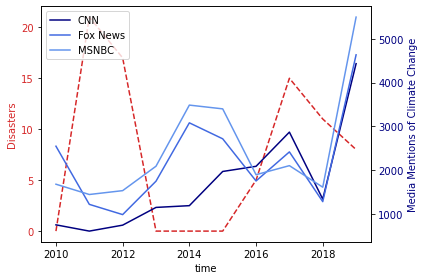

In [121]:
plot_disasters('tropical cyclone')

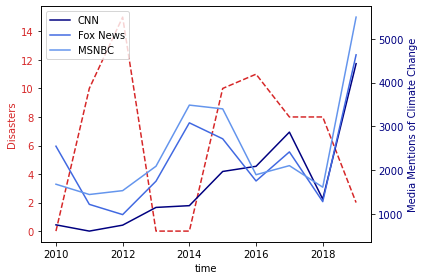

In [122]:
plot_disasters('wildfire')

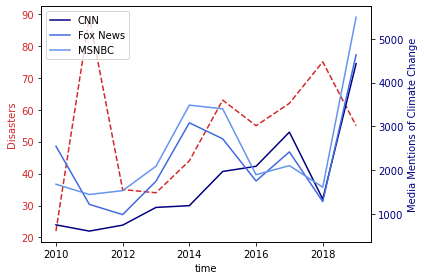

In [123]:
plot_disasters('severe storm')

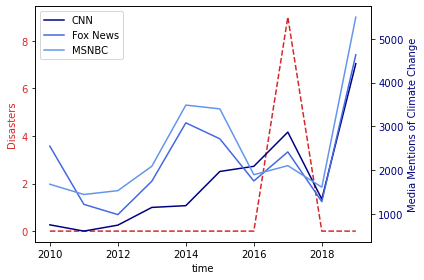

In [124]:
plot_disasters('freeze')

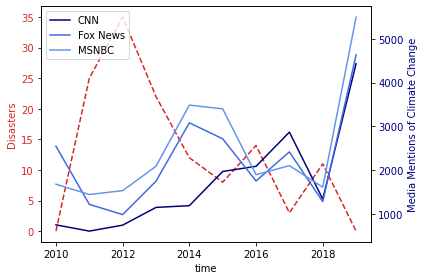

In [125]:
plot_disasters('drought')

## Kaggle Disaster Dataset

In [141]:
climate_disasters=['Fire','Severe Storm(s)','Hurricane','Flood','Coastal Storm','Typhoon']
print('Flood' in climate_disasters)

True


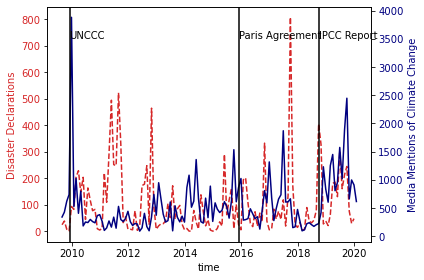

In [168]:
dist2=pd.read_csv('../us_disaster_declarations.csv')

dist2['DateTime']=pd.to_datetime(dist2.declaration_date.str.split("T", expand=True)[0], errors='ignore')
start_date="2009-08-01"
end_date="2019-12-31"

dist2=get_data_between_dates(dist2, start_date, end_date)

dist2.set_index('DateTime', inplace=True)

climate_disasters=['Fire','Severe Storm(s)','Hurricane','Flood','Coastal Storm','Typhoon']
dist2=dist2[dist2['incident_type'].isin(climate_disasters)]
#only look at 2010-2019
#only look at ih_program_declared=1, ia_program_declared=1
#only look at designated_area=statewide

#dist2=dist2[dist2.ih_program_declared==1]
#dist2=dist2[dist2.ia_program_declared==1]
#dist2=dist2[dist2.designated_area=='Statewide']

#groupby months
#group incident type, total
#print(cnn)
#print(dist2)

dist2_m = dist2.groupby(pd.Grouper(freq="M")).count()
dist2_day = dist2.groupby(pd.Grouper(freq="D")).count()

tot_day=cnn_day+fox_day+msnbc_day
tot_month=cnn_month+fox_month+msnbc_month
#dist2=dist2.groupby([dist2.DateTime.dt.to_period("M"),dist2.incident_type]).count()

fig, ax1=plt.subplots()

#fig.set_figwidth(40)
#fig.set_figheight(10)

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Disaster Declarations', color=color)
ax1.plot(dist2_m['state'], "--",color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'navy'
ax2.set_ylabel('Media Mentions of Climate Change', color=color)  # we already handled the x-label with ax1
ax2.plot(tot_month, color=color, label='Total Media Mentions')

#ax2.plot(cnn_month, color=color, label='CNN')
#ax2.plot(fox_month, color="royalblue", label='Fox News')
#ax2.plot(msnbc_month, color="cornflowerblue", label='MSNBC')

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped  

import datetime
plt.axvline(datetime.date(2009,12,7), color="black")
plt.text(datetime.date(2009,12,7), 3500, 'UNCCC')

plt.axvline(datetime.date(2015,12,12), color="black")
plt.text(datetime.date(2015,12,12), 3500, 'Paris Agreement')

plt.axvline(datetime.date(2018,10,8), color="black")
plt.text(datetime.date(2018,10,8), 3500, 'IPCC Report')



#plt.legend()
plt.show()



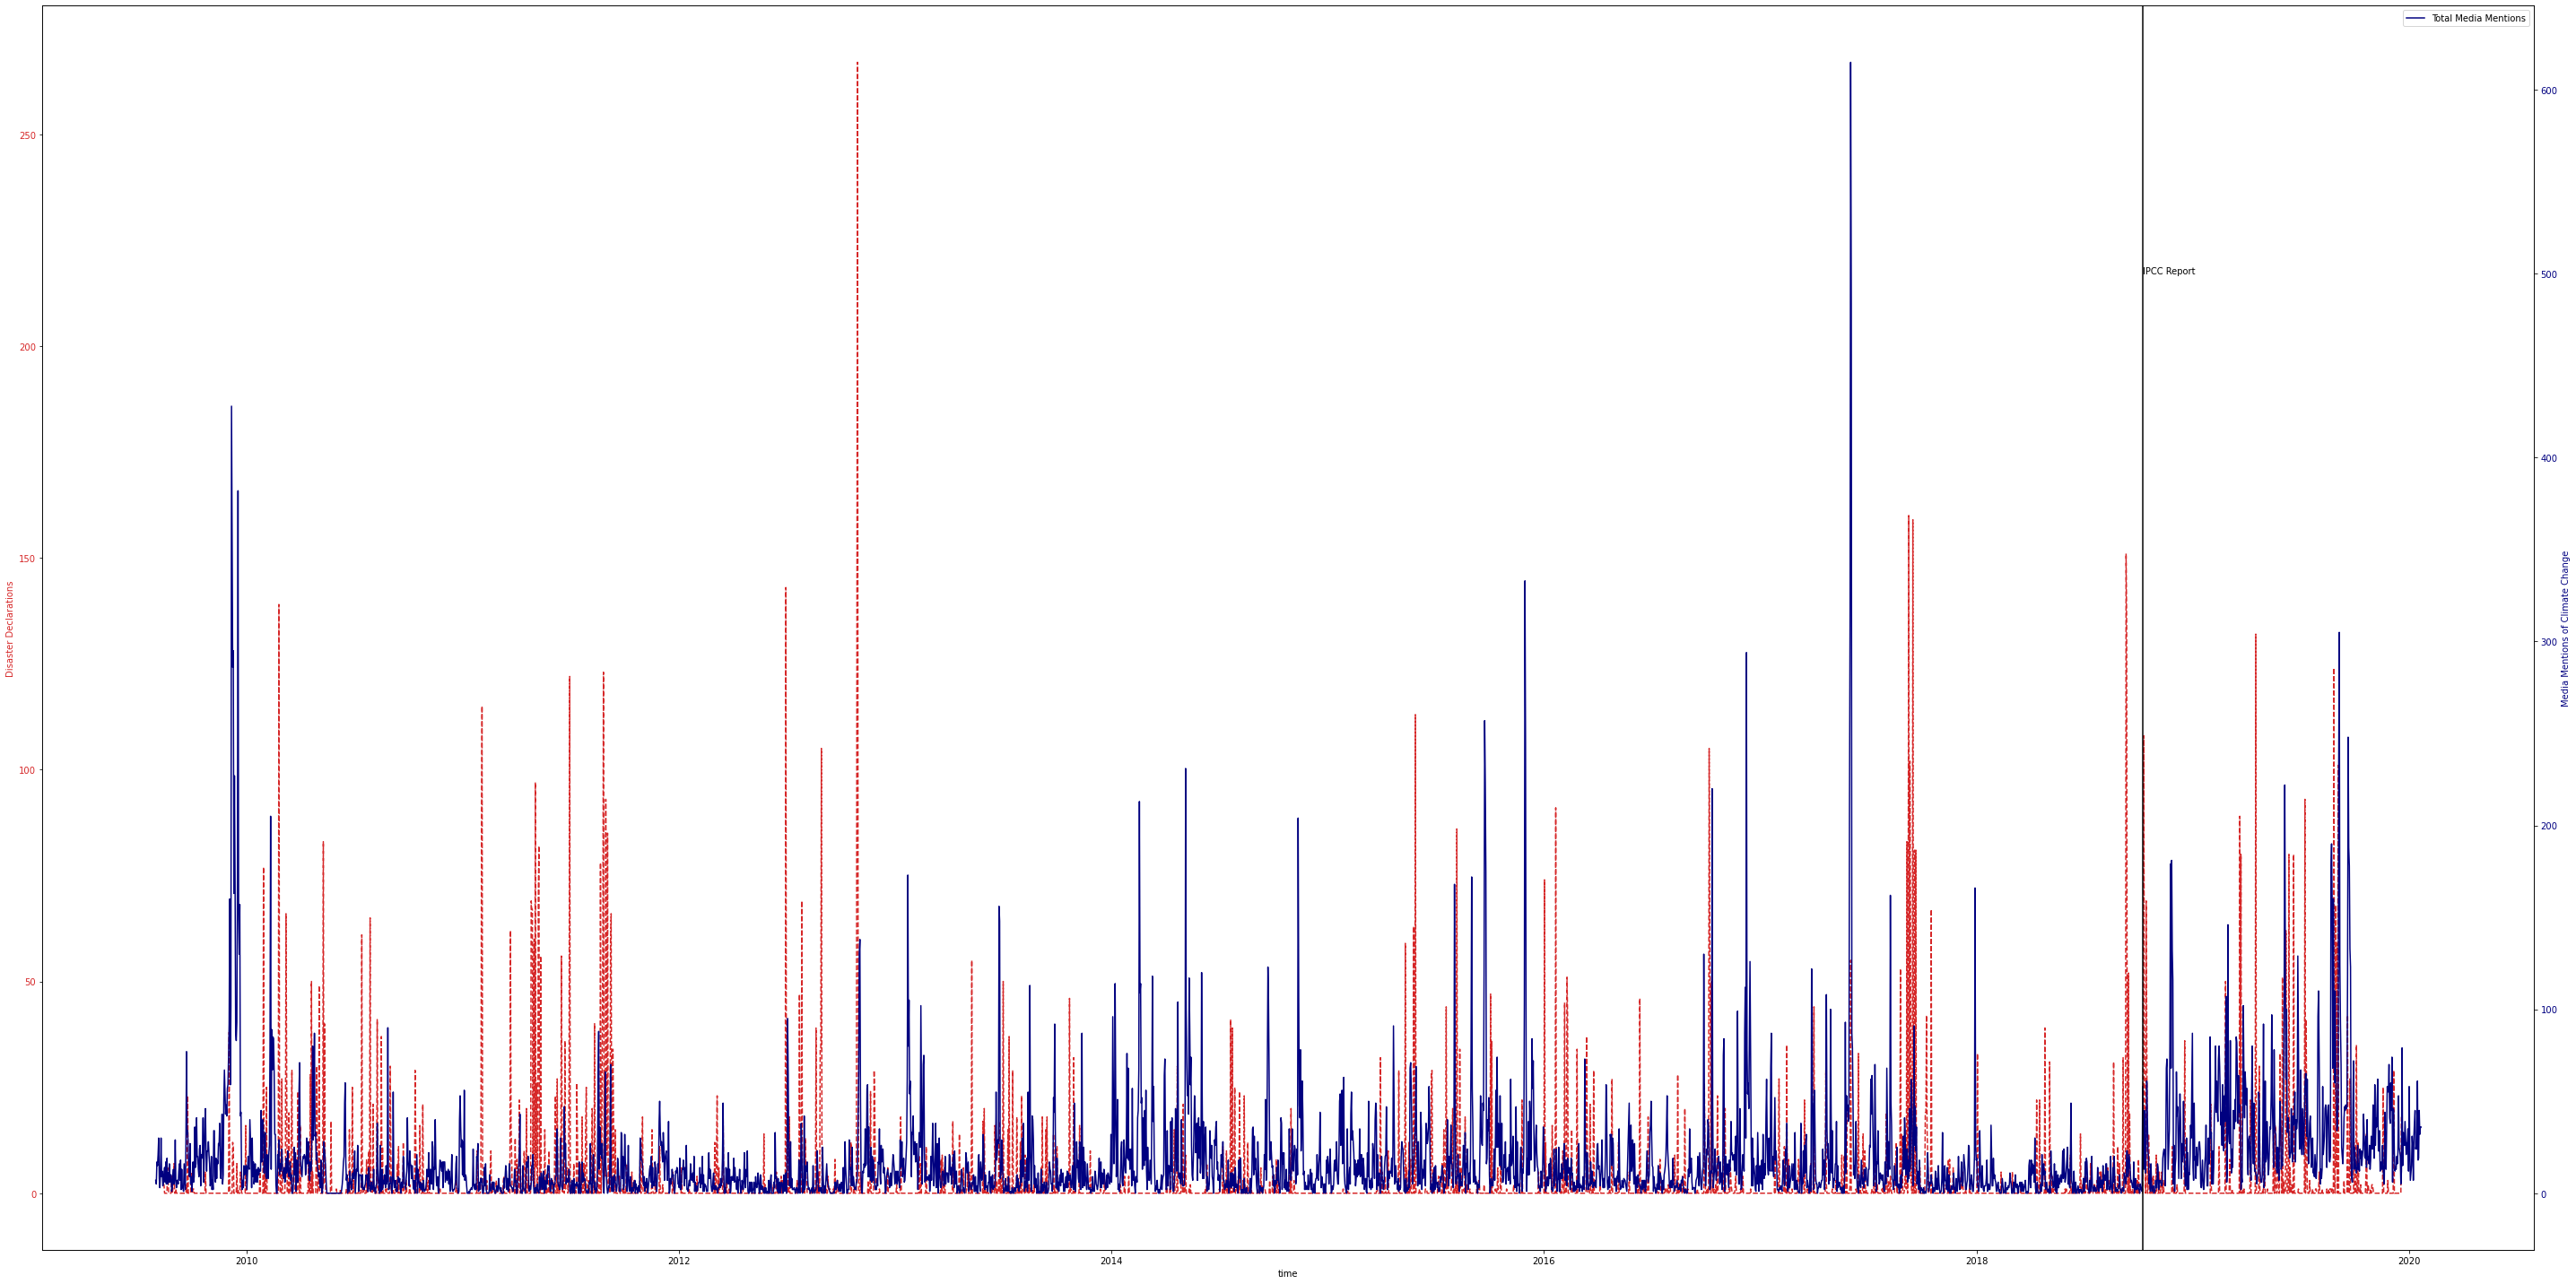

In [164]:
fig, ax1=plt.subplots()

fig.set_figwidth(40)
fig.set_figheight(20)

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Disaster Declarations', color=color)
ax1.plot(dist2_day['state'], "--",color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'navy'
ax2.set_ylabel('Media Mentions of Climate Change', color=color)  # we already handled the x-label with ax1
ax2.plot(tot_day, color=color, label='Total Media Mentions')
#ax2.plot(cnn_day, color=color, label='CNN')
#ax2.plot(fox_day, color="royalblue", label='Fox News')
#ax2.plot(msnbc_day, color="cornflowerblue", label='MSNBC')

ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(datetime.date(2018,10,8), color="black")
plt.text(datetime.date(2018,10,8), 500, 'IPCC Report')

fig.tight_layout()  # otherwise the right y-label is slightly clipped  
plt.legend()
plt.show()

In [ ]:

plt.text(datetime.date(2016,1,1), 0, 'My date')

In [91]:
dist2.declaration_date.str.split("T", expand=True)[0]

0        1953-05-02
1        1953-05-15
2        1953-05-29
3        1953-06-02
4        1953-06-06
            ...    
61883    2021-03-31
61884    2021-03-31
61885    2021-03-31
61886    2021-03-31
61887    2021-03-31
Name: 0, Length: 61888, dtype: object

In [109]:
pd.to_datetime(dist2.DateTime)
#dt.to_period("M")

41288   2011-09-03
42077   2012-07-30
42496   2012-10-29
46034   2016-07-10
Name: DateTime, dtype: datetime64[ns]